### import and read data

In [1]:
import json
import math
import os

import numpy as np
from keras import layers

from tensorflow import keras
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    # Nếu có GPU, in ra thông tin của từng GPU
    for gpu in physical_devices:
        # Lấy thông tin chi tiết của GPU
        gpu_details = tf.config.experimental.get_device_details(gpu)
        
        # # In ra tên và dung lượng RAM của GPU
        print("GPU Device:", gpu_details["device_name"])
else:
    print("No GPU available, TensorFlow is using CPU.")


GPU Device: NVIDIA GeForce RTX 2070


In [3]:

# mount google drive
WORK_PATH = 'C:/Users/ADMIN/Contacts/KLTN/data'
SAVE_PATH = 'C:/Users/ADMIN/Contacts/KLTN/model'

In [4]:

batch_size = 64
IMG_HEIGHT = int(224)
IMG_WIDTH = int(224)

In [5]:

def build_model():
    inputs = keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,3), name='inputs')
    model = keras.applications.resnet50.ResNet50(include_top= False, weights= 'imagenet', input_tensor= inputs)
    x = model.output
    x = keras.layers.GlobalAvgPool2D()(x)
    
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5,activation= 'softmax')(x)
    model = keras.Model(inputs=inputs, outputs = outputs)
    # Đóng băng 1 phần mô hình
    l = len(model.layers)
    for i, layer in enumerate(model.layers):
        if i <= 0.7*l: layer.trainable = False 
    return model



In [6]:
No_DR = 17295
Mild =3581
Moderate = 1641
Severe = 605
Proliferative_DR = 470
total=No_DR + Mild + Proliferative_DR + Severe + Moderate

weight_for_0 = (1 / Mild) * (total / 5.0)
weight_for_1 = (1 / Moderate) * (total / 5.0)
weight_for_2 = (1 / No_DR) * (total / 5.0)
weight_for_3 = (1 / Proliferative_DR) * (total / 5.0)
weight_for_4 = (1 / Severe) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}


### fold 1

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255,    
                                           rotation_range=20,
                                           horizontal_flip=True,
                                           vertical_flip=True) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_1'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_1'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22469 images belonging to 5 classes.
Found 5617 images belonging to 5 classes.


In [8]:

# callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
#                                           verbose=1,min_delta = 0.00001,
#                                           restore_best_weights=True)

#Training model
callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_MOI_fold1.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_2]
model = None
model = build_model()
model.load_weights(os.path.join(SAVE_PATH,'Model_resnet50_v1.h5'))


In [9]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')


In [10]:
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)

Epoch 1/100
352/352 [==============================] - 357s 998ms/step - loss: 1.1515 - accuracy: 0.4363 - val_loss: 1.1990 - val_accuracy: 0.4798
Epoch 2/100
352/352 [==============================] - 173s 491ms/step - loss: 0.8583 - accuracy: 0.4367 - val_loss: 1.1048 - val_accuracy: 0.5455
Epoch 3/100
352/352 [==============================] - 171s 485ms/step - loss: 0.8397 - accuracy: 0.4332 - val_loss: 1.0544 - val_accuracy: 0.5962
Epoch 4/100
352/352 [==============================] - 171s 486ms/step - loss: 0.8525 - accuracy: 0.4347 - val_loss: 1.4801 - val_accuracy: 0.3183
Epoch 5/100
352/352 [==============================] - 174s 494ms/step - loss: 0.8122 - accuracy: 0.4322 - val_loss: 1.0868 - val_accuracy: 0.5724
Epoch 6/100
352/352 [==============================] - 170s 481ms/step - loss: 0.7924 - accuracy: 0.4500 - val_loss: 1.2018 - val_accuracy: 0.4905
Epoch 7/100
352/352 [==============================] - 171s 485ms/step - loss: 0.7671 - accuracy: 0.4565 - val_loss: 1

In [14]:
# columns = ["model_name", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
# history_df = pd.DataFrame(history.history)
# history_df['model_name'] = model.name
# history_df['epoch'] = history_df.index+1
# history_df= history_df.reindex(columns=columns)
# history_df.to_csv('resnet50_fold1.csv', index=False,mode='a',header = False)

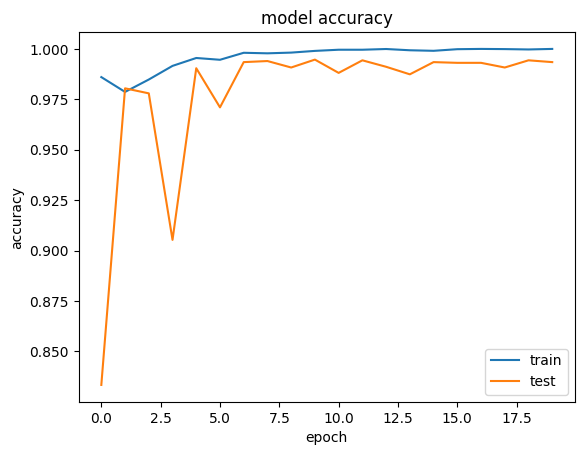

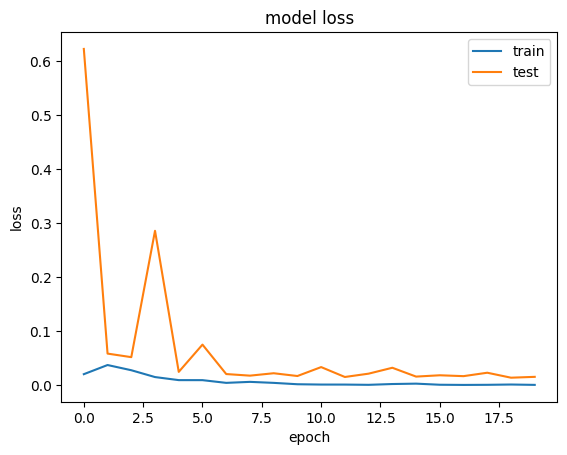

In [18]:
# Lịch sử accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Lịch sử loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### fold 2

In [19]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_2'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_2'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22468 images belonging to 5 classes.
Found 5618 images belonging to 5 classes.


In [20]:

callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
                                          verbose=1,min_delta = 0.00001,
                                          restore_best_weights=True)

#Training model
callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_MOI_fold2.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_1,callbacks_2]
model = None
model = build_model()
model.load_weights(os.path.join(SAVE_PATH,'Model_MOI_v7.h5'))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')

In [21]:
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)

Epoch 1/25
703/703 [==============================] - 134s 186ms/step - loss: 0.0397 - accuracy: 0.9780 - val_loss: 0.0605 - val_accuracy: 0.9783
Epoch 2/25
703/703 [==============================] - 80s 114ms/step - loss: 0.0215 - accuracy: 0.9905 - val_loss: 0.0139 - val_accuracy: 0.9947
Epoch 3/25
703/703 [==============================] - 80s 114ms/step - loss: 0.0064 - accuracy: 0.9966 - val_loss: 0.0100 - val_accuracy: 0.9973
Epoch 4/25
703/703 [==============================] - 78s 110ms/step - loss: 0.0028 - accuracy: 0.9987 - val_loss: 0.0172 - val_accuracy: 0.9945
Epoch 5/25
703/703 [==============================] - 78s 110ms/step - loss: 0.0054 - accuracy: 0.9963 - val_loss: 0.0202 - val_accuracy: 0.9934
Epoch 6/25
703/703 [==============================] - 78s 110ms/step - loss: 0.0095 - accuracy: 0.9952 - val_loss: 0.0146 - val_accuracy: 0.9959
Epoch 7/25
703/703 [==============================] - 77s 110ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0169 - val_a

In [22]:
columns = ["model_name", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['epoch'] = history_df.index+1
history_df= history_df.reindex(columns=columns)
history_df.to_csv('resnet50_fold2.csv', index=False,mode='a',header = False)

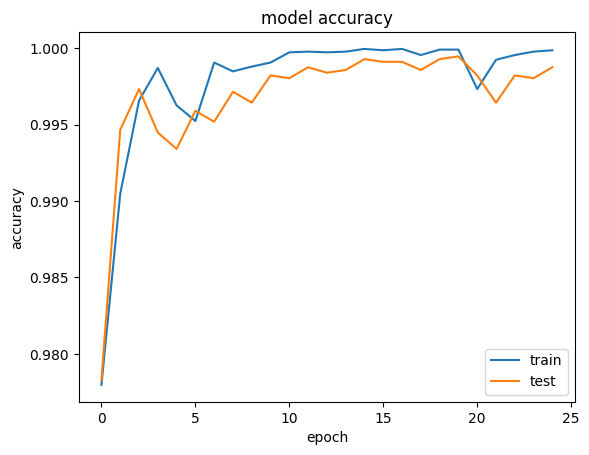

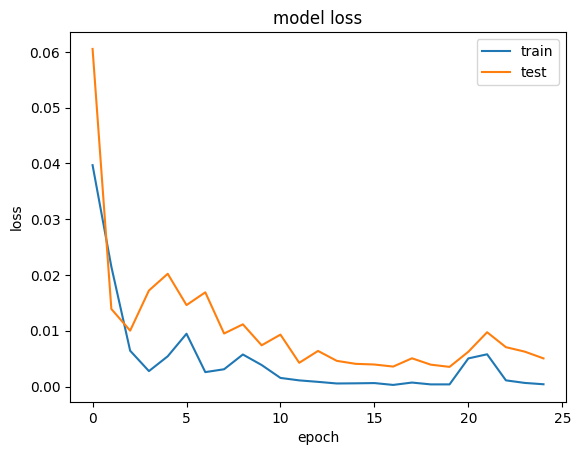

In [23]:
# Lịch sử accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Lịch sử loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### fold 3


In [24]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_3'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_3'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22469 images belonging to 5 classes.
Found 5689 images belonging to 5 classes.


In [25]:

callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
                                          verbose=1,min_delta = 0.00001,
                                          restore_best_weights=True)

#Training model
callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_MOI_fold3.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_1,callbacks_2]
model = None
model = build_model()
model.load_weights(os.path.join(SAVE_PATH,'Model_MOI_v7.h5'))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')

In [26]:
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/20
703/703 [==============================] - 134s 187ms/step - loss: 0.0306 - accuracy: 0.9810 - val_loss: 0.0297 - val_accuracy: 0.9891
Epoch 2/20
703/703 [==============================] - 80s 114ms/step - loss: 0.0242 - accuracy: 0.9846 - val_loss: 0.0250 - val_accuracy: 0.9923
Epoch 3/20
703/703 [==============================] - 80s 114ms/step - loss: 0.0153 - accuracy: 0.9897 - val_loss: 0.0169 - val_accuracy: 0.9951
Epoch 4/20
703/703 [==============================] - 78s 110ms/step - loss: 0.0053 - accuracy: 0.9965 - val_loss: 0.0231 - val_accuracy: 0.9919
Epoch 5/20
703/703 [==============================] - 80s 114ms/step - loss: 0.0039 - accuracy: 0.9985 - val_loss: 0.0810 - val_accuracy: 0.9698
Epoch 6/20
703/703 [==============================] - 81s 115ms/step - loss: 0.0038 - accuracy: 0.9977 - val_loss: 0.0168 - val_accuracy: 0.9938
Epoch 7/20
703/703 [==============================] - 78s 111ms/step - loss: 0.0020 - accuracy: 0.9988 - val_loss: 0.0130 - val_a

In [27]:
columns = ["model_name", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['epoch'] = history_df.index+1
history_df= history_df.reindex(columns=columns)
history_df.to_csv('resnet50_fold3.csv', index=False,mode='a',header = False)

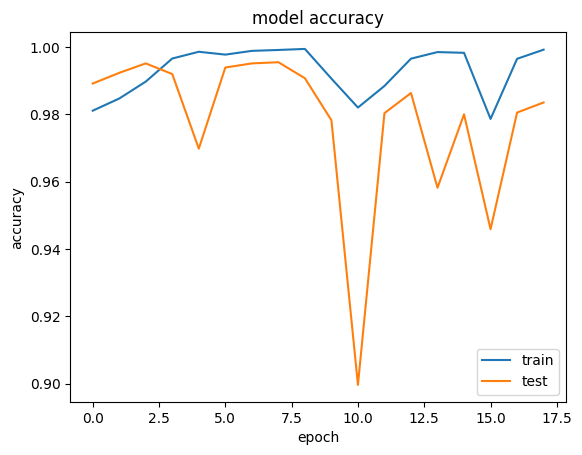

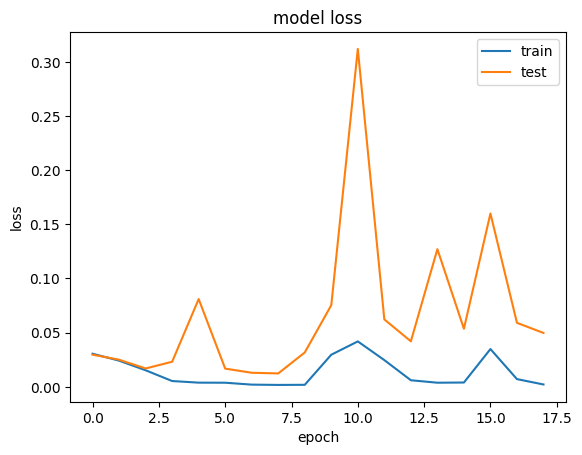

In [28]:
# Lịch sử accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Lịch sử loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### fold 4

In [29]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_4'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_4'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22541 images belonging to 5 classes.
Found 5617 images belonging to 5 classes.


In [30]:

callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
                                          verbose=1,min_delta = 0.00001,
                                          restore_best_weights=True)

#Training model
callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_MOI_fold4.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_1,callbacks_2]
model = None
model = build_model()
model.load_weights(os.path.join(SAVE_PATH,'Model_MOI_v7.h5'))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')

In [31]:
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/20
705/705 [==============================] - 149s 208ms/step - loss: 0.0272 - accuracy: 0.9829 - val_loss: 0.0101 - val_accuracy: 0.9966
Epoch 2/20
705/705 [==============================] - 78s 110ms/step - loss: 0.0248 - accuracy: 0.9870 - val_loss: 0.3174 - val_accuracy: 0.8886
Epoch 3/20
705/705 [==============================] - 78s 110ms/step - loss: 0.0247 - accuracy: 0.9838 - val_loss: 0.1298 - val_accuracy: 0.9503
Epoch 4/20
705/705 [==============================] - 78s 110ms/step - loss: 0.0349 - accuracy: 0.9811 - val_loss: 0.0891 - val_accuracy: 0.9678
Epoch 5/20
705/705 [==============================] - 78s 110ms/step - loss: 0.0358 - accuracy: 0.9879 - val_loss: 0.2043 - val_accuracy: 0.9258
Epoch 6/20
705/705 [==============================] - 78s 111ms/step - loss: 0.0192 - accuracy: 0.9918 - val_loss: 0.0458 - val_accuracy: 0.9833
Epoch 7/20
705/705 [==============================] - 78s 110ms/step - loss: 0.0226 - accuracy: 0.9908 - val_loss: 0.1183 - val_a

In [32]:
columns = ["model_name", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['epoch'] = history_df.index+1
history_df= history_df.reindex(columns=columns)
history_df.to_csv('resnet50_fold4.csv', index=False,mode='a',header = False)

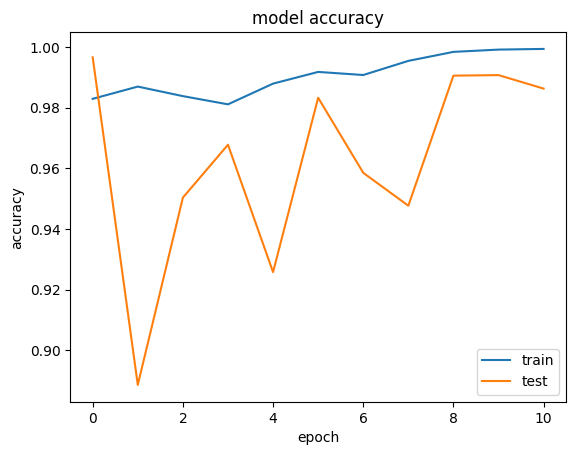

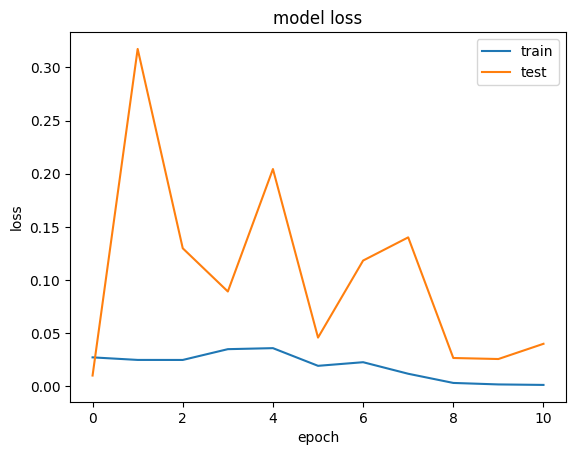

In [33]:
# Lịch sử accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Lịch sử loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### fold 5

In [9]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'train_5'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

i_val = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'vali_5'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 22469 images belonging to 5 classes.
Found 5617 images belonging to 5 classes.


In [10]:

callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
                                          verbose=1,min_delta = 0.00001,
                                          restore_best_weights=True)

#Training model
callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_MOI_fold5.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_1,callbacks_2]
model = None
model = build_model()
model.load_weights(os.path.join(SAVE_PATH,'Model_MOI_v7.h5'))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')

In [34]:
history = model.fit(i_train,validation_data = i_val ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/100
705/705 [==============================] - 78s 110ms/step - loss: 0.0211 - accuracy: 0.9872 - val_loss: 0.0247 - val_accuracy: 0.9913
Epoch 2/100
705/705 [==============================] - 78s 110ms/step - loss: 0.0069 - accuracy: 0.9960 - val_loss: 0.0136 - val_accuracy: 0.9955
Epoch 3/100
705/705 [==============================] - 80s 113ms/step - loss: 0.0041 - accuracy: 0.9981 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 4/100
705/705 [==============================] - 77s 110ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 0.0043 - val_accuracy: 0.9984
Epoch 5/100
705/705 [==============================] - 80s 113ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0030 - val_accuracy: 0.9993
Epoch 6/100
705/705 [==============================] - 77s 110ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 7/100
705/705 [==============================] - 78s 110ms/step - loss: 7.4078e-04 - accuracy: 0.9999 - val_loss: 0.00

In [12]:
columns = ["model_name", "epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
history_df = pd.DataFrame(history.history)
history_df['model_name'] = model.name
history_df['epoch'] = history_df.index+1
history_df= history_df.reindex(columns=columns)
history_df.to_csv('resnet50_fold5.csv', index=False,mode='a',header = False)

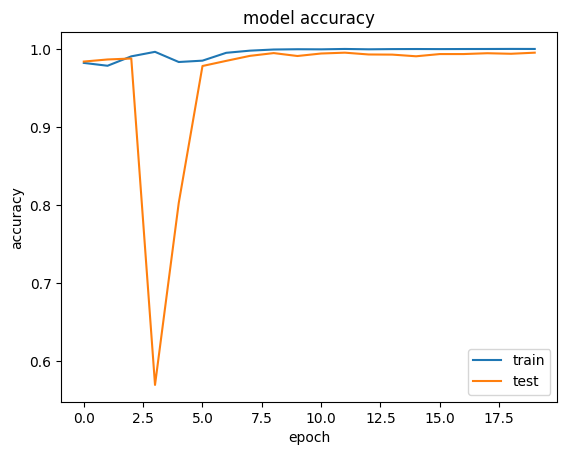

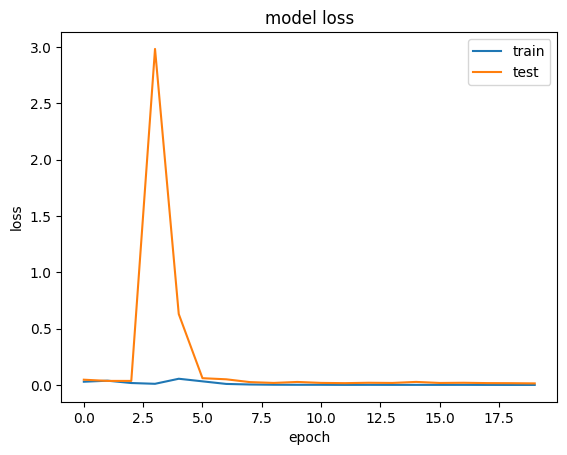

In [13]:
# Lịch sử accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# Lịch sử loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [16]:
model.save_weights(os.path.join(SAVE_PATH,'Model_finalv1.h5'))

### Train all

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

i_train = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'Train_all'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))


Found 28086 images belonging to 5 classes.


In [9]:

test_image_generator = ImageDataGenerator(rescale=1./255)
i_test = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=os.path.join(WORK_PATH,'test'),
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 7022 images belonging to 5 classes.


In [17]:
model = None
model = build_model()
model.load_weights(os.path.join(SAVE_PATH,'Model_finalv1.h5'))


In [18]:

callbacks_1 = keras.callbacks.EarlyStopping(monitor="val_accuracy",patience = 10,
                                          verbose=1,min_delta = 0.00001,
                                          restore_best_weights=True)

#Training model
callbacks_2 = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(SAVE_PATH,'Model_MOI_all.h5'),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callbacks = [callbacks_1,callbacks_2]

In [20]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')

history = model.fit(i_train,validation_data = i_test ,epochs = 100,callbacks = callbacks,class_weight=class_weight)


Epoch 1/100
1756/1756 [==============================] - 152s 85ms/step - loss: 0.0870 - accuracy: 0.9552 - val_loss: 0.2686 - val_accuracy: 0.9003
Epoch 2/100
1756/1756 [==============================] - 149s 85ms/step - loss: 0.0312 - accuracy: 0.9806 - val_loss: 0.2284 - val_accuracy: 0.9191
Epoch 3/100
1756/1756 [==============================] - 145s 82ms/step - loss: 0.0175 - accuracy: 0.9889 - val_loss: 0.2740 - val_accuracy: 0.9077
Epoch 4/100
1756/1756 [==============================] - 147s 84ms/step - loss: 0.0161 - accuracy: 0.9906 - val_loss: 0.2422 - val_accuracy: 0.9200
Epoch 5/100
1756/1756 [==============================] - 145s 82ms/step - loss: 0.0103 - accuracy: 0.9939 - val_loss: 0.2683 - val_accuracy: 0.9193
Epoch 6/100
1756/1756 [==============================] - 148s 84ms/step - loss: 0.0056 - accuracy: 0.9968 - val_loss: 0.2364 - val_accuracy: 0.9318
Epoch 7/100
1756/1756 [==============================] - 148s 84ms/step - loss: 0.0044 - accuracy: 0.9978 - val_

In [21]:
model.save_weights(os.path.join(SAVE_PATH,'Model_final.h5'))

### test

In [ ]:
def load_images(file_paths):
    if file_paths:
        images = []
        for file_path in file_paths:
            img = keras.utils.load_img(file_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = keras.utils.img_to_array(img)
            img = img / 255.0
            images.append(img)
        return np.array(images)
def predict_images(model, file_paths):
    images = load_images(file_paths)
    # predictions = np.argmax(model.predict(images), axis = 1)
    # return np.array([labels[i] for i in predictions])
    return model.predict(images)
y_pred = predict_images(model,[os.path.join(SAVE_PATH,"2496_right.jpeg"),os.path.join(SAVE_PATH,"99_left.jpeg")])
np.argmax(y_pred, axis=1)

In [ ]:
model = None
model = build_model()
model.save_weights(os.path.join(SAVE_PATH,'Model_final.h5'))
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001,
                                              amsgrad=True),
            loss='categorical_crossentropy',metrics='accuracy')

In [22]:
model.evaluate(i_test)

439/439 [==============================] - 22s 50ms/step - loss: 0.2495 - accuracy: 0.9435


[0.2494591772556305, 0.9434633851051331]

In [115]:
img, label = i_test.next()

In [116]:
# Predict
y_pred = np.argmax(model.predict(img), axis=-1)
y_true = np.argmax(label, axis=-1)

1/1 [==============================] - 1s 826ms/step


In [117]:
# Accuracy
metrics_acc  = tf.keras.metrics.Accuracy()
metrics_acc.update_state(y_true,y_pred)
metrics_acc.result().numpy()

1.0

In [118]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [119]:
#Classification_report
print(classification_report(y_true,y_pred,target_names=labels))

NameError: name 'labels' is not defined

In [ ]:
# Confusion_matrix
confusion_matrix(y_true,y_pred)